In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima



In [115]:
df = pd.read_excel('/Users/easydong/DataspellProjects/timeseries/dm_team/profit_bgr.xlsx', index_col = 0)
df.index = pd.to_datetime(df.index)
df.head()

,profit
year,
2010-01-01,129135734744
2010-04-01,200290041719
2010-07-01,218300602955
2010-10-01,137174329687
2011-01-01,140461544652


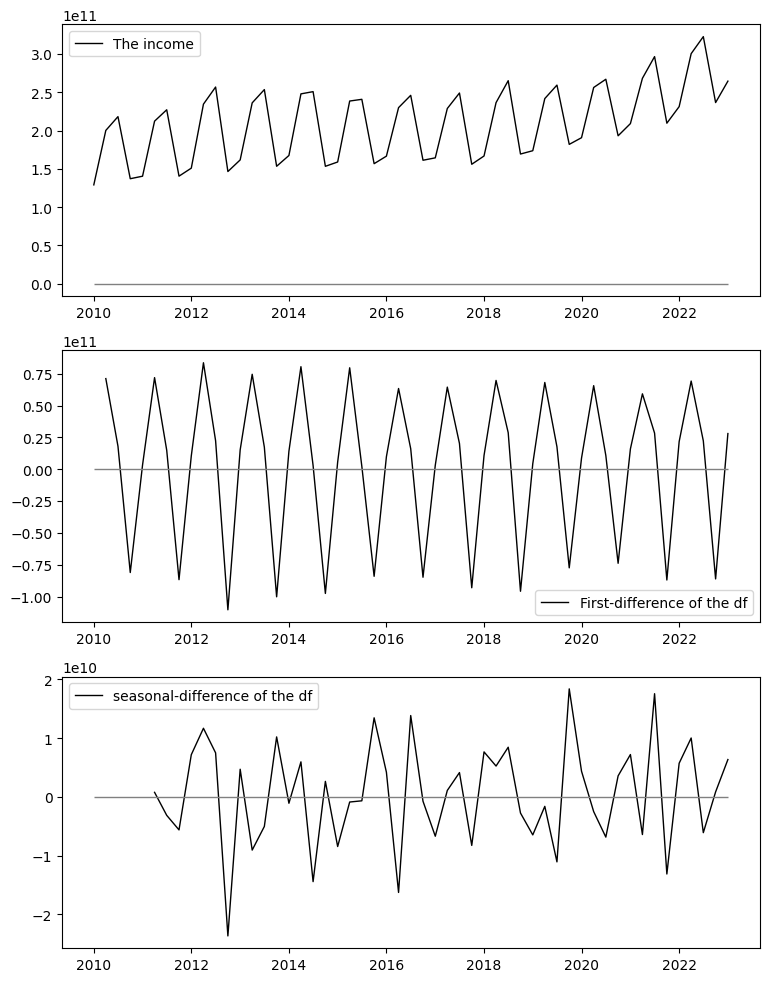

In [116]:
f, axes = plt.subplots(nrows=3, ncols=1, figsize= (9, 3*4))
axes[0].plot(df, color='black', linewidth=1, label='The income')
axes[0].hlines(xmin= df.index[0], xmax=df.index[-1], y=0,color='gray', linewidth= 1)
axes[0].legend()

#1차 차분
axes[1].plot(df.diff(),color='black',linewidth=1,label='First-difference of the df')
axes[1].hlines(xmin=df.index[0],xmax=df.index[-1],y=0,color='gray',linewidth=1)
axes[1].legend()

#계절성 차분 (period = 4)
axes[2].plot(df.diff().diff(4),color='black',linewidth=1,label='seasonal-difference of the df')
axes[2].hlines(xmin=df.index[0],xmax=df.index[-1],y=0,color='gray',linewidth=1)
axes[2].legend()

plt.show()

In [117]:
def adf_test(dataframe):
    result = adfuller(dataframe,maxlag=4)
    print(f'Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical values: {result[4]}')

def kpss_test(dataframe):
    result = kpss(dataframe)
    print(f'Statistics: {result[0]}')
    print(f'bounded p-value: {result[1]}')
    print(f'Critical values: {result[3]}')


In [118]:
df_differenced = df.diff().dropna()
df_seasonal_differenced = df.diff(4).diff().dropna()
print("origin")
adf_test(df)
kpss_test(df)
print("-"*20)
print("differenced")
adf_test(df_differenced)
kpss_test(df_differenced)
print("-"*20)
print("differenced+seasonal_differenced")
adf_test(df_seasonal_differenced)
kpss_test(df_seasonal_differenced)

origin
Statistics: 2.000856897433963
p-value: 0.9986740636105066
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Statistics: 0.7263922320146242
bounded p-value: 0.011146160725943252
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
--------------------
differenced
Statistics: -2.4604274661198224
p-value: 0.12540196545408294
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Statistics: 0.3376535666874484
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
--------------------
differenced+seasonal_differenced
Statistics: -9.302436300669536
p-value: 1.1032456926260305e-15
Critical values: {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}
Statistics: 0.3131643763963905
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


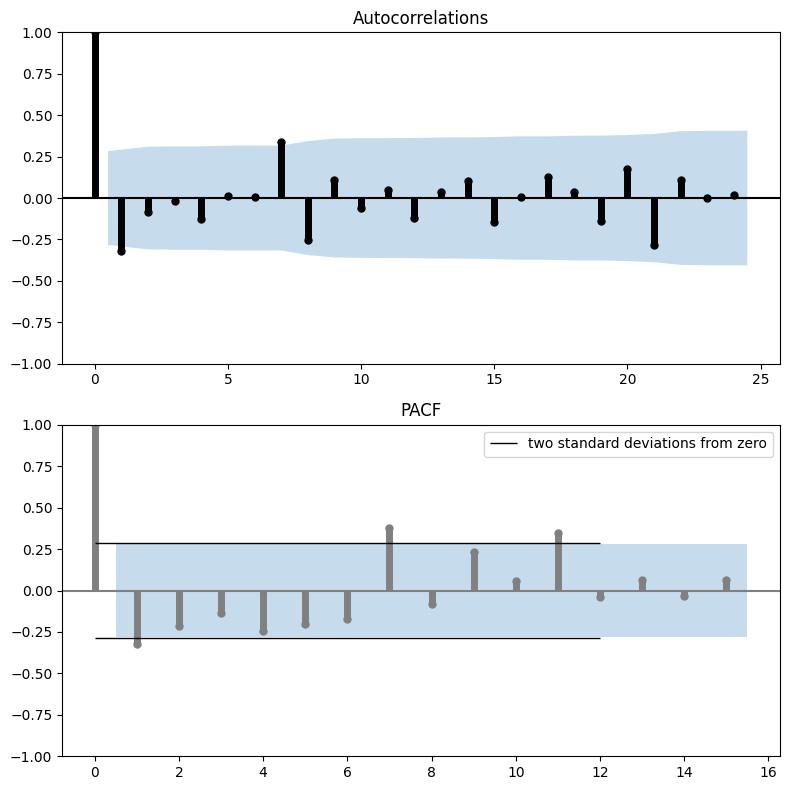

In [119]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,2*4))
plot_acf(df_seasonal_differenced, lags= 24, ax=axes[0], title='Autocorrelations',
         color = 'black', vlines_kwargs={'colors' : 'black', 'linewidth' : 5})
plot_pacf(df_seasonal_differenced, lags=15,ax=axes[1], method='ols', title='PACF', color='gray',
          vlines_kwargs={'colors': 'gray', 'linewidth':5})

axes[1].hlines(xmin=0,xmax=12,y=2*np.sqrt(1/len(df_seasonal_differenced)), label='two standard deviations from zero', color='black', linewidth=1)
axes[1].hlines(xmin=0,xmax=12,y=-2*np.sqrt(1/len(df_seasonal_differenced)), color='black', linewidth=1)

axes[1].legend()
plt.tight_layout()
plt.show()

In [120]:
model_1 = sm.tsa.statespace.SARIMAX(df_seasonal_differenced, trend='c',order=(0, 0, 1), seasonal_order=(0,0,0,4)).fit()
model_2 = sm.tsa.statespace.SARIMAX(df_seasonal_differenced, trend='c',order=(1, 0, 1), seasonal_order=(0,0,0,4)).fit()
model_3 = sm.tsa.statespace.SARIMAX(df_seasonal_differenced, trend='c',order=(1, 0, 1), seasonal_order=(1,0,1,4)).fit()
summary_table = dict()

idx = 0
res_result = []
num_of_obs = len(df)
for model in [model_1, model_2, model_3]:
    res = model

    temp_perf_dict = {key: key for key in ['SSE','AIC','SBC','Q(4)','Q(8)','Q(12)']}
    temp_perf_dict['SSE'] = round(res.sse,3)
    temp_perf_dict['AIC'] = round(num_of_obs*np.log(res.sse) + 2*len(res.params),3)
    temp_perf_dict['SBC'] = round(num_of_obs*np.log(res.sse) + len(res.params)*np.log(num_of_obs),3)
    q_statistics = res.test_serial_correlation(method='ljungbox',lags=12)[0]
    temp_perf_dict['Q(4)'] = {'q_stats' : round(q_statistics[0][3],2), 'p_val':round(q_statistics[1][3],3)}
    temp_perf_dict['Q(8)'] = {'q_stats' : round(q_statistics[0][7],2), 'p_val':round(q_statistics[1][7],3)}
    temp_perf_dict['Q(12)'] = {'q_stats' : round(q_statistics[0][11],2),'p_val': round(q_statistics[1][11],3)}
    for param_name, param in zip(res.params.index, res.params): temp_perf_dict[param_name] = {'coef':round(param,3), 't_stats':round(res.tvalues[param_name],3)}
    hashable_order = tuple([tuple(order) if isinstance(order,list) == True else order for order in res.specification['order']])
    hashable_s_order = tuple([tuple(s_order) if isinstance(s_order,list) == True else s_order for s_order in res.specification['seasonal_order']])
    summary_table[(hashable_order,hashable_s_order)] = temp_perf_dict


    res_result.append(res)





RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42392D+01    |proj g|=  5.23699D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   1.421D-08   2.424D+01
  F =   24.235538745519648     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.4

/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
 This pr

In [121]:
result_table = pd.DataFrame()
for key, value in summary_table.items():
    temp_series = pd.Series(value, name=key)
    result_table = pd.concat([result_table,temp_series],axis=1)

In [122]:
result_table

,"((0, 0, 1), (0, 0, 0, 4))","((1, 0, 1), (0, 0, 0, 4))","((1, 0, 1), (1, 0, 1, 4))"
SSE,3131458256455624818688.0,3133616548408676319232.0,2970828079435211603968.0
AIC,2629.277,2631.313,2632.486
SBC,2635.188,2639.194,2644.308
Q(4),"{'q_stats': 3.56, 'p_val': 0.469}","{'q_stats': 2.6, 'p_val': 0.627}","{'q_stats': 0.71, 'p_val': 0.95}"
Q(8),"{'q_stats': 11.97, 'p_val': 0.153}","{'q_stats': 10.86, 'p_val': 0.21}","{'q_stats': 9.63, 'p_val': 0.292}"
Q(12),"{'q_stats': 13.24, 'p_val': 0.352}","{'q_stats': 12.2, 'p_val': 0.43}","{'q_stats': 10.14, 'p_val': 0.604}"
intercept,"{'coef': 926622938.448, 't_stats': 3.231016075...","{'coef': 983868215.607, 't_stats': 6.696691230...","{'coef': 983868215.607, 't_stats': 5.867708373..."
ma.L1,"{'coef': -0.52, 't_stats': -4.38}","{'coef': -0.561, 't_stats': -2.61}","{'coef': -0.635, 't_stats': -2.516}"
sigma2,"{'coef': 7.027815560516597e+19, 't_stats': 8.4...","{'coef': 6.951044421655036e+19, 't_stats': 4.5...","{'coef': 6.951044421655036e+19, 't_stats': 9.1..."
ar.L1,NaN,"{'coef': 0.081, 't_stats': 0.314}","{'coef': 0.105, 't_stats': 0.301}"


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


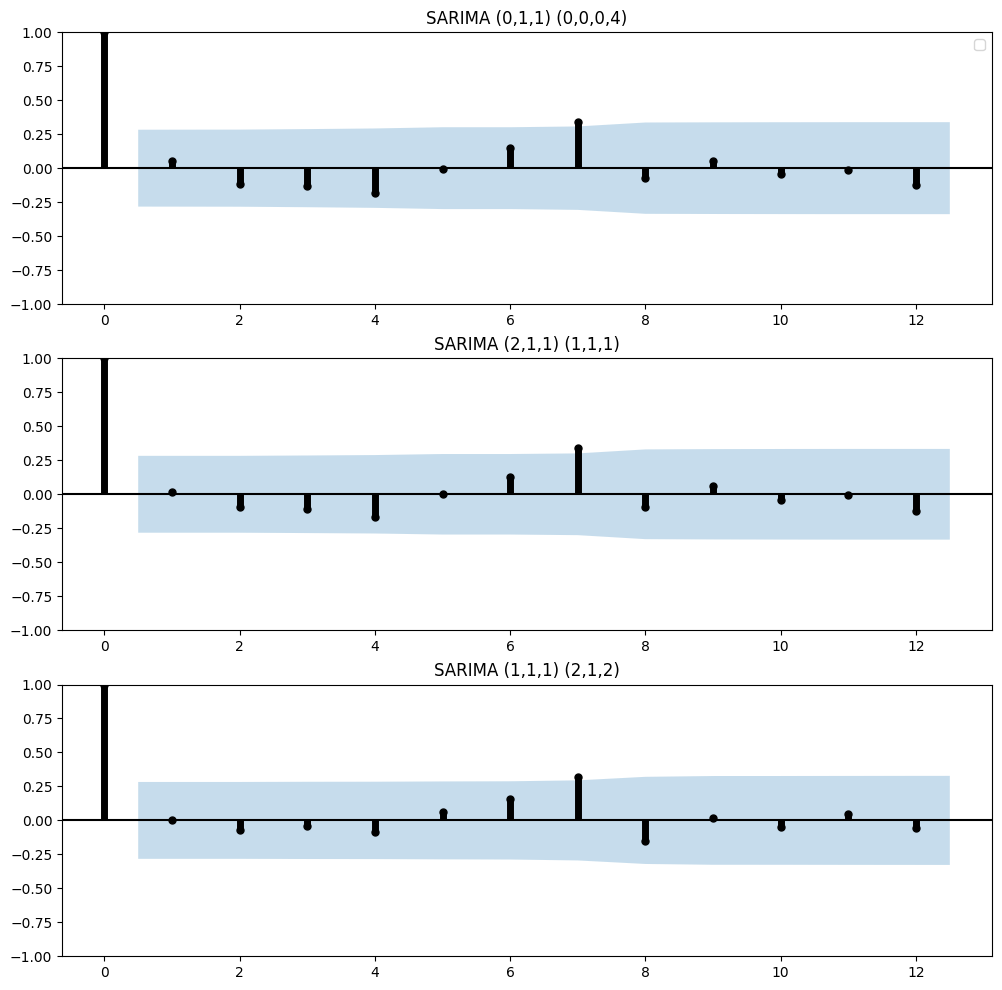

In [123]:
f, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,12))
plot_acf(res_result[0].resid, lags=12, ax=axes[0], title='SARIMA (0,1,1) (0,0,0,4)', color='black',vlines_kwargs={'colors':'black','linewidth':5})
axes[0].legend()
plot_acf(res_result[1].resid, lags=12, ax=axes[1], title='SARIMA (2,1,1) (1,1,1)', color='black',vlines_kwargs={'colors':'black','linewidth':5})
axes[0].legend()
plot_acf(res_result[2].resid, lags=12, ax=axes[2], title='SARIMA (1,1,1) (2,1,2)', color='black',vlines_kwargs={'colors':'black','linewidth':5})
axes[0].legend()
plt.show()


In [124]:
#auto_arima를 이용해서 주기 찾기

#train 2010Q1~2021Q4 test 2022Q1~2023Q1

checker = df.index <= '2021-10-01'

train_set = df[checker]
test_set = df[~checker]

model = sm.tsa.statespace.SARIMAX(train_set, trend='c',order=(0, 1, 1), seasonal_order=(0,1,0,4)).fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24325D+01    |proj g|=  2.94887D+00

At iterate    5    f=  2.18035D+01    |proj g|=  6.16301D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   6.892D-08   2.180D+01
  F =   21.803240280519166     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [125]:
forcast_model = model.forecast(5)

In [126]:
real = df.iloc[len(df)-5:,:]
real
forcast_model
sum = 0


for i in range(0,5):
    MAPE =abs((real.iloc[i,:].values[0]-forcast_model[i])/real.iloc[i,:].values[0]) * 100/5
print(f'MAPE : {round(MAPE,2)}%')

MAPE : 1.35%


In [127]:
print(MAPE)

1.3530259830971323


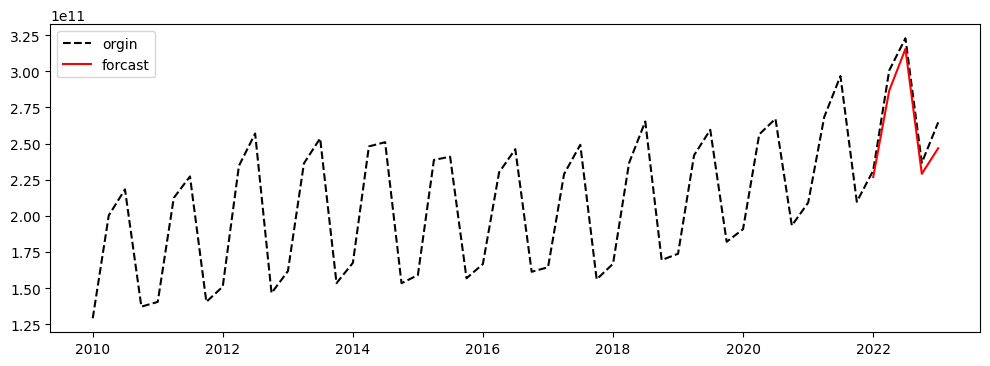

In [128]:
# plot the results
plt.figure(figsize=(12,4))
plt.plot(df, label='orgin', color='k', linestyle='--')
plt.plot(forcast_model, label='forcast', color='r')
plt.legend()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25736D+01    |proj g|=  2.94044D+00

At iterate    5    f=  2.19434D+01    |proj g|=  4.89770D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   2.558D-08   2.194D+01
  F =   21.943256760392075     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


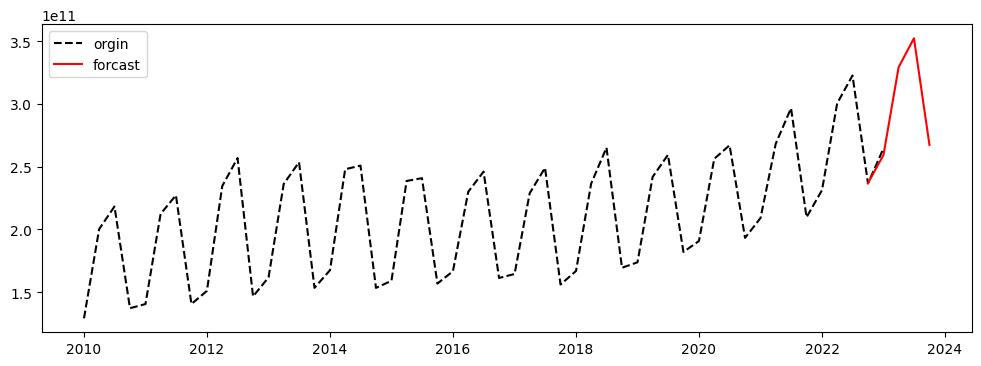

In [129]:
model = sm.tsa.statespace.SARIMAX(df[:-2], trend='c',order=(0, 1, 1), seasonal_order=(0,1,0,4)).fit().forecast(5)
plt.figure(figsize=(12,4))
plt.plot(df, label='orgin', color='k', linestyle='--')
plt.plot(model, label='forcast', color='r')
plt.legend()
plt.show()



In [131]:
model

2022-10-01    2.369771e+11
2023-01-01    2.594245e+11
2023-04-01    3.294546e+11
2023-07-01    3.525100e+11
2023-10-01    2.674595e+11
Freq: QS-OCT, Name: predicted_mean, dtype: float64